In [1]:
using LightGraphs, RCall, LightGraphsFlows, Suppressor, Gadfly, DataFrames, CSV, PyCall, Compose

In [2]:
R"library('genlasso')";
include("code/BGSM_general.jl");
include("code/BGSM_biclust.jl");
include("code/model_selection.jl");
include("code/l0pen.jl");
using PyCall
@pyimport GraphSegment
@pyimport numpy

Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [5]:
function BGSM(y, D; mult = 1.3, num = 30, st = 1e-3 * 2)
    v0_range = st * mult.^(0:num-1); a = Inf; bgsm1 = 0; bgsm2 = 0;
    t = 0;
    for i = 1:length(v0_range)
        tic();
        temp = BGSM_general(y,D, v0 = v0_range[i], v1 = 1e4, A = n, b = n,
                                    convtol = 1e-8, iter = 100, verbose = false);
        t = t + toq();
        bgsm_ms = model_selection(temp);
        #println(sum(D * bgsm_ms[:beta] .> 1e-8))
        #println(bgsm_ms[:score])
        if bgsm_ms[:score] < a
            a = bgsm_ms[:score];
            bgsm1 = temp[:alpha] + temp[:theta];
            bgsm2 = bgsm_ms[:t_full];
        end
    end
    
    return Dict([(:thetahat, bgsm1), (:theta, bgsm2), (:t, t)])
end

function genlasso(y)
    t = 0;
    tic();
    @rput y;
    R"out =  trendfilter(y, ord=0);";
    t = t + toq();
    @suppress begin
    R"cv = cv.trendfilter(out);
    out_fl = coef(out, lambda=cv$lambda.min, verbose = FALSE)$beta;";
    end;
    @rget out_fl;
    
    return Dict([(:theta, out_fl), (:t, t)])
end

function l0pen(y; B = 10, mult = 2.0, sigma = 1, delta = 0.01)
    t = 0;
    edges = GraphSegment.Edges_1D(n);
    err   = zeros(10, B);
    out_l0pen = 0;
    tic();
    for b = 1:B
        for i = 1:10
            @suppress begin
            out_l0pen = GraphSegment.GraphSegment(y,edges, mult^(i-4), delta=delta);
            #sigmahat  = norm(y - out_l0pen)/sqrt(n);
            alpha     = 0.2;
            z         = alpha * sigma * randn(n);
            y1        = y + z;
            y2        = y - z/alpha^2;
            mu1       = GraphSegment.GraphSegment(y1,edges, mult^(i-4), delta=delta);
            err[i,b]  = norm(y2 - mu1)^2/n;
            end;
        end
    end
    t = toq();
    
    score = sum(err, 2);
    minind = findmin(score)[2]
    @suppress begin
    out_l0pen = GraphSegment.GraphSegment(y,edges, mult^(minind - 4), delta=delta);
    end;
    
    return Dict([(:theta, out_l0pen), (:err, err), (:t, t)])
end

l0pen (generic function with 1 method)

In [8]:
srand(1);
delta = repeat([1:5;4;3;4;2;3], inner = 2) .* (-1).^(1:20); randn();
theta = cumsum(delta);
theta = repeat(theta, inner = 50);
y     = theta + .5 * randn(1000);
n     = length(y);
g     = PathGraph(n);
D     = -incidence_matrix(g, oriented = true)';

In [266]:
set_default_plot_size(20cm, 15cm)
p1 = Gadfly.layer(y = theta, Geom.line);
p2 = Gadfly.layer(y = y, Geom.point, Theme(point_size = 1pt));
Gadfly.plot(p1, p2);

In [384]:
mse_bgsm   = zeros(10); mse_genlasso = zeros(10); mse_l0pen = zeros(10);
theta_bgsm = zeros(1000,10); theta_genlasso = zeros(1000,10); theta_l0pen = zeros(1000,10);
changes    = zeros(3,10);
t          = zeros(3,10);


srand(2018);
for i = 1:10
    y     = theta + .5 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 5);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1 = zeros(10,5); fit2 = zeros(10,5); fit3 = zeros(10,5); fitc = zeros(3,5); fitt = zeros(3,5)
fit1[:,5] = copy(mse_bgsm);
fit2[:,5] = copy(mse_genlasso);
fit3[:,5] = copy(mse_l0pen);
fitc[:,5] = mean(changes, 2)[:];
fitt[:,5] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .4 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,4] = copy(mse_bgsm);
fit2[:,4] = copy(mse_genlasso);
fit3[:,4] = copy(mse_l0pen);
fitc[:,4] = mean(changes, 2)[:];
fitt[:,4] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .3 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,3] = copy(mse_bgsm);
fit2[:,3] = copy(mse_genlasso);
fit3[:,3] = copy(mse_l0pen);
fitc[:,3] = mean(changes, 2)[:];
fitt[:,3] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .2 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,2] = copy(mse_bgsm);
fit2[:,2] = copy(mse_genlasso);
fit3[:,2] = copy(mse_l0pen);
fitc[:,2] = mean(changes, 2)[:];
fitt[:,2] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .1 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,1] = copy(mse_bgsm);
fit2[:,1] = copy(mse_genlasso);
fit3[:,1] = copy(mse_l0pen);
fitc[:,1] = mean(changes, 2)[:];
fitt[:,1] = mean(t, 2)[:];

genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done;

In [317]:
srand(5);
y            = theta + .5 * randn(1000);
@time out_bgsm     = BGSM(y, D, mult = 2.0, num = 20, st = 1e-3 * 2);
@time out_genlasso = genlasso(y);
@time out_l0pen    = l0pen(y; B = 10, mult = 2.0);
println(norm(theta - out_bgsm[:theta])^2/n)
println(norm(theta - out_genlasso[:theta])^2/n)
println(norm(theta - out_l0pen[:theta])^2/n)
F1 = plot(y = out_bgsm[:theta], Geom.line);
F2 = plot(y = out_genlasso[:theta], Geom.line);
F3 = plot(y = out_l0pen[:theta], Geom.line);
srand(7);
y  = theta + .5 * randn(1000);
@time out_l0pen2 = l0pen(y; B = 5, mult = 2.0);

  2.328486 seconds (3.00 M allocations: 2.546 GiB, 27.00% gc time)
 12.248453 seconds (2.20 k allocations: 466.984 KiB)
 26.238212 seconds (656.36 k allocations: 30.544 MiB, 0.18% gc time)
0.029742692597904092
0.019533004656686205
0.004771943948401349


In [375]:
df = DataFrame(bgsm = out_bgsm[:theta], genlasso = out_genlasso[:theta][:],
               l0pen = out_l0pen[:theta], l0pen2 = out_l0pen2[:theta],
               y = y);
CSV.write("result/linearpatheven2.txt", df, delim = ',');

In [362]:
p1 = layer(y = out_bgsm[:theta], Geom.line, Theme(line_width = .6mm, default_color = "green"));
p2 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F1 = Gadfly.plot(p1,p2, Guide.title("BGSM"));
p3 = layer(y = out_genlasso[:theta], Geom.line, Theme(line_width = .6mm, default_color = "red"));
p4 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F2 = Gadfly.plot(p3,p4, Guide.title("Genlasso"));
p5 = layer(y = out_l0pen[:theta], Geom.line, Theme(line_width = .6mm, default_color = "blue"));
p6 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F3 = Gadfly.plot(p5,p6, Guide.title("L0pen (best)"))
p7 = layer(y = out_l0pen2[:theta], Geom.line, Theme(line_width = .6mm, default_color = "purple"));
p8 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F4 = Gadfly.plot(p7,p8, Guide.title("L0pen (worst)"));
set_default_plot_size(41cm, 10.5cm)
F = Gadfly.title(hstack(compose(context(0, 0, 10cm, 10cm), render(F1)),
    compose(context(0, 0, 10cm, 10cm), render(F2)),
    compose(context(0, 0, 10cm, 10cm), render(F3)),
    compose(context(0, 0, 10cm, 10cm), render(F4))),
    "Linear path graph (equal spacing)");
draw(PDF("figure/temp1.pdf"),F)

In [395]:
df = DataFrame(sigma = [1:5;1:5;1:5]/10, mse = [mean(fit1, 1) mean(fit2, 1) mean(fit3, 1)][:],
               t = fitt'[:], change = fitc'[:], method = r2[:method]);
r1 = copy(df); r1[:x] = r1[:sigma]; r1[:y] = r1[:mse]; r1[:c] = r1[:change];

In [418]:
p1 = Gadfly.plot(r1, x = :x, y = :y, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("mean squared error"), Guide.xlabel("n"), Guide.ylabel("mse"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
p2 = Gadfly.plot(r1, x = :x, y = :t, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("computation time"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10))
p3 = Gadfly.plot(r1, x = :x, y = :c, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("number of changes"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
set_default_plot_size(45cm, 13cm)
F9 = title(hstack(compose(context(0, 0, 14cm, 13cm), render(p1)),
    compose(context(0, 0, 14cm, 13cm), render(p3)),
    compose(context(0, 0, 16cm, 13cm), render(p2))), "linear path graph")
Gadfly.draw(PDF("F9.pdf"), F9);

In [419]:
CSV.write("result/linearpatheven3.txt", r1, delim = ',');

In [423]:
srand(1);
delta = repeat([1:5;4;3;4;3;4], inner = 2) .* (-1).^(1:20); randn();
theta = cumsum(delta);
theta = repeat(theta, inner = 50);
for i = 1:20
    theta[1 + (i-1) * 50 : 40 + (i-1) * 50] = 0;
end
y     = theta + .5 * randn(1000);

In [424]:
mse_bgsm   = zeros(10); mse_genlasso = zeros(10); mse_l0pen = zeros(10);
theta_bgsm = zeros(1000,10); theta_genlasso = zeros(1000,10); theta_l0pen = zeros(1000,10);
changes    = zeros(3,10);
t          = zeros(3,10);


srand(2018);
for i = 1:10
    y     = theta + .5 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 5);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1 = zeros(10,5); fit2 = zeros(10,5); fit3 = zeros(10,5); fitc = zeros(3,5); fitt = zeros(3,5)
fit1[:,5] = copy(mse_bgsm);
fit2[:,5] = copy(mse_genlasso);
fit3[:,5] = copy(mse_l0pen);
fitc[:,5] = mean(changes, 2)[:];
fitt[:,5] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .4 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,4] = copy(mse_bgsm);
fit2[:,4] = copy(mse_genlasso);
fit3[:,4] = copy(mse_l0pen);
fitc[:,4] = mean(changes, 2)[:];
fitt[:,4] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .3 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,3] = copy(mse_bgsm);
fit2[:,3] = copy(mse_genlasso);
fit3[:,3] = copy(mse_l0pen);
fitc[:,3] = mean(changes, 2)[:];
fitt[:,3] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .2 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,2] = copy(mse_bgsm);
fit2[:,2] = copy(mse_genlasso);
fit3[:,2] = copy(mse_l0pen);
fitc[:,2] = mean(changes, 2)[:];
fitt[:,2] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .1 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,1] = copy(mse_bgsm);
fit2[:,1] = copy(mse_genlasso);
fit3[:,1] = copy(mse_l0pen);
fitc[:,1] = mean(changes, 2)[:];
fitt[:,1] = mean(t, 2)[:];

genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done;

In [435]:
df = DataFrame(sigma = [1:5;1:5;1:5]/10, mse = [mean(fit1, 1) mean(fit2, 1) mean(fit3, 1)][:],
               t = fitt'[:], change = fitc'[:], method = r1[:method]);
r2 = copy(df); r2[:x] = r2[:sigma]; r2[:y] = r2[:mse]; r2[:c] = r2[:change];
CSV.write("result/linearpathuneven3.txt", r2, delim = ',');

In [377]:
srand(5);
y            = theta + .5 * randn(1000);
@time out_bgsm     = BGSM(y, D, mult = 2.0, num = 20, st = 1e-3 * 2);
@time out_genlasso = genlasso(y);
@time out_l0pen    = l0pen(y; B = 10, mult = 2.0);
println(norm(theta - out_bgsm[:theta])^2/n)
println(norm(theta - out_genlasso[:theta])^2/n)
println(norm(theta - out_l0pen[:theta])^2/n)
F1 = plot(y = out_bgsm[:theta], Geom.line);
F2 = plot(y = out_genlasso[:theta], Geom.line);
F3 = plot(y = out_l0pen[:theta], Geom.line);
srand(7);
y  = theta + .5 * randn(1000);
@time out_l0pen2 = l0pen(y; B = 5, mult = 2.0);
println(norm(theta - out_l0pen2[:theta])^2/n);

  5.009504 seconds (5.33 M allocations: 4.776 GiB, 28.75% gc time)
 12.473451 seconds (2.20 k allocations: 467.031 KiB)
 21.889034 seconds (656.35 k allocations: 30.543 MiB, 0.19% gc time)
0.015558839789766599
0.022448943244746656
0.007222727940449334


In [379]:
df2 = DataFrame(bgsm = out_bgsm[:theta], genlasso = out_genlasso[:theta][:],
               l0pen = out_l0pen[:theta], l0pen2 = out_l0pen2[:theta],
               y = y);
CSV.write("result/linearpathuneven2.txt", df2, delim = ',');

In [381]:
p1 = layer(y = out_bgsm[:theta], Geom.line, Theme(line_width = .6mm, default_color = "green"));
p2 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F1 = Gadfly.plot(p1,p2, Guide.title("BGSM"));
p3 = layer(y = out_genlasso[:theta], Geom.line, Theme(line_width = .6mm, default_color = "red"));
p4 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F2 = Gadfly.plot(p3,p4, Guide.title("Genlasso"));
p5 = layer(y = out_l0pen[:theta], Geom.line, Theme(line_width = .6mm, default_color = "blue"));
p6 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F3 = Gadfly.plot(p5,p6, Guide.title("L0pen (best)"))
p7 = layer(y = out_l0pen2[:theta], Geom.line, Theme(line_width = .6mm, default_color = "purple"));
p8 = layer(y = y, Geom.point, Theme(default_color = "black", point_size = 1.2pt));
F4 = Gadfly.plot(p7,p8, Guide.title("L0pen (worst)"));
set_default_plot_size(41cm, 10.5cm)
F = Gadfly.title(hstack(compose(context(0, 0, 10cm, 10cm), render(F1)),
    compose(context(0, 0, 10cm, 10cm), render(F2)),
    compose(context(0, 0, 10cm, 10cm), render(F3)),
    compose(context(0, 0, 10cm, 10cm), render(F4))),
    "Linear path graph (unequal spacing)");
draw(PDF("figure/temp2.pdf"),F)

In [173]:
mse_bgsm   = zeros(10); mse_genlasso = zeros(10); mse_l0pen = zeros(10);
theta_bgsm = zeros(1000,10); theta_genlasso = zeros(1000,10); theta_l0pen = zeros(1000,10);
changes    = zeros(3,10);
t          = zeros(3,10);

srand(2018);
for i = 1:10
    y     = theta + .5 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1 = zeros(10,5); fit2 = zeros(10,5); fit3 = zeros(10,5); fitc = zeros(3,5); fitt = zeros(3,5)
fit1[:,5] = copy(mse_bgsm);
fit2[:,5] = copy(mse_genlasso);
fit3[:,5] = copy(mse_l0pen);
fitc[:,5] = mean(changes, 2)[:];
fitt[:,5] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .4 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,4] = copy(mse_bgsm);
fit2[:,4] = copy(mse_genlasso);
fit3[:,4] = copy(mse_l0pen);
fitc[:,4] = mean(changes, 2)[:];
fitt[:,4] = mean(t, 2)[:];

genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 


In [174]:
srand(2018);
for i = 1:10
    y     = theta + .3 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,3] = copy(mse_bgsm);
fit2[:,3] = copy(mse_genlasso);
fit3[:,3] = copy(mse_l0pen);
fitc[:,3] = mean(changes, 2)[:];
fitt[:,3] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .2 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,2] = copy(mse_bgsm);
fit2[:,2] = copy(mse_genlasso);
fit3[:,2] = copy(mse_l0pen);
fitc[:,2] = mean(changes, 2)[:];
fitt[:,2] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .1 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,1] = copy(mse_bgsm);
fit2[:,1] = copy(mse_genlasso);
fit3[:,1] = copy(mse_l0pen);
fitc[:,1] = mean(changes, 2)[:];
fitt[:,1] = mean(t, 2)[:];

genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done;

In [198]:
df = DataFrame(sigma = [1:5;1:5;1:5]/10, mse = [mean(fit1, 1) mean(fit2, 1) mean(fit3, 1)][:],
               t = fitt'[:], change = fitc'[:], method = r1[:method]);
r2 = copy(df); r2[:x] = r2[:sigma]; r2[:y] = r2[:mse]; r2[:c] = r2[:change]
CSV.write("result/linearpathuneven1.txt", r2, delim = ',');

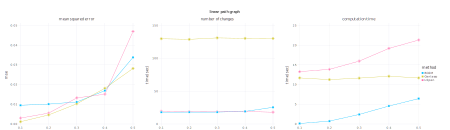

In [199]:
p1 = Gadfly.plot(r2, x = :x, y = :y, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("mean squared error"), Guide.xlabel("n"), Guide.ylabel("mse"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
p2 = Gadfly.plot(r2, x = :x, y = :t, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("computation time"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10))
p3 = Gadfly.plot(r2, x = :x, y = :c, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("number of changes"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
set_default_plot_size(45cm, 13cm)
F9 = title(hstack(compose(context(0, 0, 14cm, 13cm), render(p1)),
    compose(context(0, 0, 14cm, 13cm), render(p3)),
    compose(context(0, 0, 16cm, 13cm), render(p2))), "linear path graph")
Gadfly.draw(PDF("F9.pdf"), F9);
F9

In [263]:
r2

,sigma,mse,t,change,method,x,y,c
1,0.1,0.00949495,0.126165,18.0,BGSM,0.1,0.00949495,18.0
2,0.2,0.0101029,0.728599,18.1,BGSM,0.2,0.0101029,18.1
3,0.3,0.0111601,2.42024,18.1,BGSM,0.3,0.0111601,18.1
4,0.4,0.016935,4.55976,19.2,BGSM,0.4,0.016935,19.2
5,0.5,0.0338193,6.44126,25.4,BGSM,0.5,0.0338193,25.4
6,0.1,0.00115667,11.6924,129.9,Genlasso,0.1,0.00115667,129.9
7,0.2,0.00458465,11.2637,129.0,Genlasso,0.2,0.00458465,129.0
8,0.3,0.0102416,11.6495,131.2,Genlasso,0.3,0.0102416,131.2
9,0.4,0.0181399,12.1311,130.5,Genlasso,0.4,0.0181399,130.5
10,0.5,0.0281843,11.6905,130.3,Genlasso,0.5,0.0281843,130.3


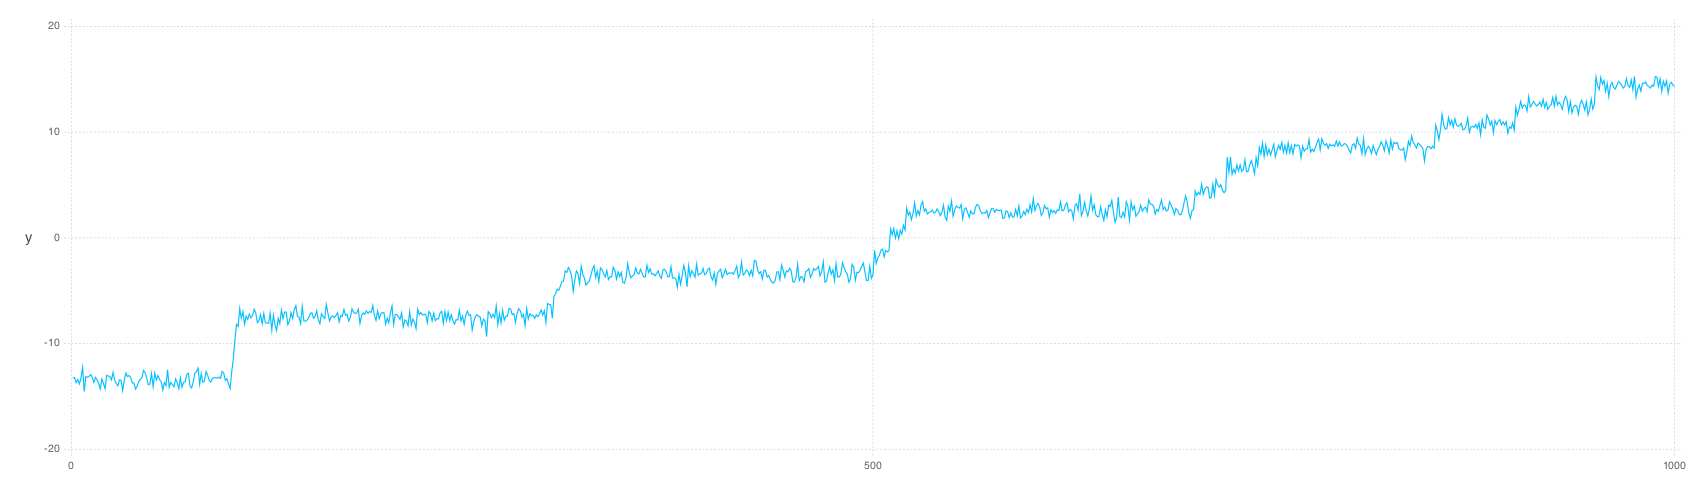

In [228]:
srand(1);
delta = zeros(n-1);
delta[[100;101;102; 300;305;300;500;510;520;700;720;740;850;900;950]] = 2;
theta = -pinv(full(D)) * delta;
y     = theta + .5 * randn(1000);
Gadfly.plot(y = y, Geom.line);

In [229]:
mse_bgsm   = zeros(10); mse_genlasso = zeros(10); mse_l0pen = zeros(10);
theta_bgsm = zeros(1000,10); theta_genlasso = zeros(1000,10); theta_l0pen = zeros(1000,10);
changes    = zeros(3,10);
t          = zeros(3,10);

srand(2018);
for i = 1:10
    y     = theta + .5 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1 = zeros(10,5); fit2 = zeros(10,5); fit3 = zeros(10,5); fitc = zeros(3,5); fitt = zeros(3,5)
fit1[:,5] = copy(mse_bgsm);
fit2[:,5] = copy(mse_genlasso);
fit3[:,5] = copy(mse_l0pen);
fitc[:,5] = mean(changes, 2)[:];
fitt[:,5] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .4 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,4] = copy(mse_bgsm);
fit2[:,4] = copy(mse_genlasso);
fit3[:,4] = copy(mse_l0pen);
fitc[:,4] = mean(changes, 2)[:];
fitt[:,4] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .3 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,3] = copy(mse_bgsm);
fit2[:,3] = copy(mse_genlasso);
fit3[:,3] = copy(mse_l0pen);
fitc[:,3] = mean(changes, 2)[:];
fitt[:,3] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .2 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,2] = copy(mse_bgsm);
fit2[:,2] = copy(mse_genlasso);
fit3[:,2] = copy(mse_l0pen);
fitc[:,2] = mean(changes, 2)[:];
fitt[:,2] = mean(t, 2)[:];
srand(2018);
for i = 1:10
    y     = theta + .1 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.5, num = 10, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    changes[1,i] = sum(abs.(D*out_bgsm[:theta]) .> 1e-8);
    changes[2,i]  = sum(abs.(D*out_genlasso[:theta]) .> 1e-8);
    changes[3,i]  = sum(abs.(D*out_l0pen[:theta]) .> 1e-8);
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,1] = copy(mse_bgsm);
fit2[:,1] = copy(mse_genlasso);
fit3[:,1] = copy(mse_l0pen);
fitc[:,1] = mean(changes, 2)[:];
fitt[:,1] = mean(t, 2)[:];

genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done;

In [236]:
df = DataFrame(sigma = [1:5;1:5;1:5]/10, mse = [mean(fit1, 1) mean(fit2, 1) mean(fit3, 1)][:],
               t = fitt'[:], change = fitc'[:], method = r1[:method]);
r3 = copy(df); r3[:x] = r3[:sigma]; r3[:y] = r3[:mse]; r3[:c] = r3[:change]
CSV.write("result/linearpathincreasing1.txt", r3, delim = ',');

In [262]:
p1 = Gadfly.plot(r3, x = :x, y = :y, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("mean squared error"), Guide.xlabel("n"), Guide.ylabel("mse"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
p2 = Gadfly.plot(r3, x = :x, y = :t, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("computation time"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10))
p3 = Gadfly.plot(r3, x = :x, y = :c, color = :method, shape = :method, Geom.point, Geom.line,
                Coord.cartesian(xmin = 0.1, xmax = 0.5),
                Guide.title("number of changes"), Guide.xlabel("n"), Guide.ylabel("time(sec)"),
                Theme(point_size = 4pt, key_position = :none),
                shape = repeat([Shape.square, Shape.utriangle, Shape.cross], inner = 10));
set_default_plot_size(45cm, 13cm)
F9 = title(hstack(compose(context(0, 0, 14cm, 13cm), render(p1)),
    compose(context(0, 0, 14cm, 13cm), render(p3)),
    compose(context(0, 0, 16cm, 13cm), render(p2))), "linear path graph")
Gadfly.draw(PDF("F9.pdf"), F9);

In [9]:
srand(2);
delta = repeat([1:5;4;3;4;3;4], inner = 2) .* (-1).^(1:20); randn();
theta = cumsum(delta);
theta = repeat(theta, inner = 50);
for i = 1:20
    theta[1 + (i-1) * 50 : 48 + (i-1) * 50] = 0;
end
y     = theta + .5 * randn(1000);

In [10]:
function l0pen(y; B = 10, mult = 2.0, sigma = 1, delta = 0.1)
    t = 0;
    edges = GraphSegment.Edges_1D(n);
    err   = zeros(10, B);
    out_l0pen = 0;
    tic();
    for b = 1:B
        for i = 1:10
            @suppress begin
            out_l0pen = GraphSegment.GraphSegment(y,edges, mult^(i-4), delta=delta);
            #sigmahat  = norm(y - out_l0pen)/sqrt(n);
            alpha     = 0.2;
            z         = alpha * sigma * randn(n);
            y1        = y + z;
            y2        = y - z/alpha^2;
            mu1       = GraphSegment.GraphSegment(y1,edges, mult^(i-4), delta=delta);
            err[i,b]  = norm(y2 - mu1)^2/n;
            end;
        end
    end
    t = toq();
    
    score = sum(err, 2);
    minind = findmin(score)[2]
    @suppress begin
    out_l0pen = GraphSegment.GraphSegment(y,edges, mult^(minind - 4), delta=delta);
    end;
    
    return Dict([(:theta, out_l0pen), (:err, err), (:t, t)])
end

l0pen (generic function with 1 method)

In [33]:
tind = find(abs.(D * theta) .> 1e-8);

2

In [64]:
mse_bgsm   = zeros(10); mse_genlasso = zeros(10); mse_l0pen = zeros(10);
theta_bgsm = zeros(1000,10); theta_genlasso = zeros(1000,10); theta_l0pen = zeros(1000,10);
fdr        = zeros(3,10); power = zeros(3,10);
t          = zeros(3,10);
fit1 = zeros(10,5); fit2 = zeros(10,5); fit3 = zeros(10,5);
fitfdr = zeros(3,5); fitpower = zeros(3,5); fitt = zeros(3,5);

srand(2018);
for i = 1:10
    y     = theta + .5 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    nzind = find(abs.(D * out_bgsm[:theta]) .> 1e-8);
    fdr[1,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[1,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_genlasso[:theta]) .> 1e-8);
    fdr[2,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[2,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_l0pen[:theta]) .> 1e-8);
    fdr[3,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[3,i]    = length(findin(tind, nzind))/length(tind)
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,5] = copy(mse_bgsm);
fit2[:,5] = copy(mse_genlasso);
fit3[:,5] = copy(mse_l0pen);
fitfdr[:,5] = mean(fdr, 2)[:];
fitpower[:,5] = mean(power, 2)[:];
fitt[:,5] = mean(t, 2)[:];



srand(2018);
for i = 1:10
    y     = theta + .4 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    nzind = find(abs.(D * out_bgsm[:theta]) .> 1e-8);
    fdr[1,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[1,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_genlasso[:theta]) .> 1e-8);
    fdr[2,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[2,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_l0pen[:theta]) .> 1e-8);
    fdr[3,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[3,i]    = length(findin(tind, nzind))/length(tind)
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,4] = copy(mse_bgsm);
fit2[:,4] = copy(mse_genlasso);
fit3[:,4] = copy(mse_l0pen);
fitfdr[:,4] = mean(fdr, 2)[:];
fitpower[:,4] = mean(power, 2)[:];
fitt[:,4] = mean(t, 2)[:];



srand(2018);
for i = 1:10
    y     = theta + .3 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    nzind = find(abs.(D * out_bgsm[:theta]) .> 1e-8);
    fdr[1,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[1,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_genlasso[:theta]) .> 1e-8);
    fdr[2,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[2,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_l0pen[:theta]) .> 1e-8);
    fdr[3,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[3,i]    = length(findin(tind, nzind))/length(tind)
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,3] = copy(mse_bgsm);
fit2[:,3] = copy(mse_genlasso);
fit3[:,3] = copy(mse_l0pen);
fitfdr[:,3] = mean(fdr, 2)[:];
fitpower[:,3] = mean(power, 2)[:];
fitt[:,3] = mean(t, 2)[:];




srand(2018);
for i = 1:10
    y     = theta + .2 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    nzind = find(abs.(D * out_bgsm[:theta]) .> 1e-8);
    fdr[1,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[1,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_genlasso[:theta]) .> 1e-8);
    fdr[2,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[2,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_l0pen[:theta]) .> 1e-8);
    fdr[3,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[3,i]    = length(findin(tind, nzind))/length(tind)
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,2] = copy(mse_bgsm);
fit2[:,2] = copy(mse_genlasso);
fit3[:,2] = copy(mse_l0pen);
fitfdr[:,2] = mean(fdr, 2)[:];
fitpower[:,2] = mean(power, 2)[:];
fitt[:,2] = mean(t, 2)[:];




srand(2018);
for i = 1:10
    y     = theta + .1 * randn(1000);
    tic();
    out_genlasso = genlasso(y);
    t[2,i] = toq();
    print("genlasso done; ")
    tic();
    out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-3 * 2);
    t[1,i] = toq();
    print("bgsm done; ")
    tic();
    out_l0pen    = l0pen(y; B = 10, mult = 2.0);
    t[3,i] = toq();
    print("l0pen done; \n")
    nzind = find(abs.(D * out_bgsm[:theta]) .> 1e-8);
    fdr[1,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[1,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_genlasso[:theta]) .> 1e-8);
    fdr[2,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[2,i]    = length(findin(tind, nzind))/length(tind)
    nzind = find(abs.(D * out_l0pen[:theta]) .> 1e-8);
    fdr[3,i]      = 1 - length(findin(tind, nzind))/length(nzind);
    power[3,i]    = length(findin(tind, nzind))/length(tind)
        
    mse_bgsm[i] = norm(theta - out_bgsm[:theta])^2/n;
    mse_genlasso[i] = norm(theta - out_genlasso[:theta])^2/n;
    mse_l0pen[i] = norm(theta - out_l0pen[:theta])^2/n;
    
    theta_bgsm[:,i] = out_bgsm[:theta];
    theta_genlasso[:,i] = out_genlasso[:theta];
    theta_l0pen[:,i] = out_l0pen[:theta];
end
fit1[:,1] = copy(mse_bgsm);
fit2[:,1] = copy(mse_genlasso);
fit3[:,1] = copy(mse_l0pen);
fitfdr[:,1] = mean(fdr, 2)[:];
fitpower[:,1] = mean(power, 2)[:];
fitt[:,1] = mean(t, 2)[:];




genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done; l0pen done; 
genlasso done; bgsm done;

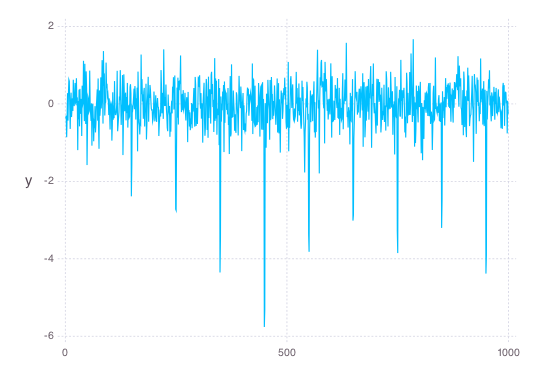

In [81]:
Gadfly.plot(y = y, Geom.line)

In [83]:
srand(5);
y            = theta + .5 * randn(1000);
n     = length(y);
g     = PathGraph(n);
D     = -incidence_matrix(g, oriented = true)';
srand(1)
@time out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-2/5);
srand(1)
@time out_genlasso = genlasso(y);
srand(1)
@time out_l0pen    = l0pen(y; B = 10, mult = 2.0);
println(norm(theta - out_bgsm[:theta])^2/n)
println(norm(theta - out_genlasso[:theta])^2/n)
println(norm(theta - out_l0pen[:theta])^2/n)
F1 = plot(y = out_bgsm[:theta], Geom.line);
F2 = plot(y = out_genlasso[:theta], Geom.line);
F3 = plot(y = out_l0pen[:theta], Geom.line);
srand(12);
y  = theta + .5 * randn(1000);
@time out_l0pen2 = l0pen(y; B = 5, mult = 2.0);
println(norm(theta - out_l0pen2[:theta])^2/n)

 16.130351 seconds (17.46 M allocations: 16.140 GiB, 23.47% gc time)
 10.488025 seconds (2.22 k allocations: 532.953 KiB)
  2.181294 seconds (657.81 k allocations: 43.588 MiB, 1.64% gc time)
0.015528101746628968
0.04440689755314801
0.09789373083661448
  1.152793 seconds (339.04 k allocations: 22.322 MiB, 1.78% gc time)
0.23768591607767242


In [59]:
srand(1);
@time out_bgsm     = BGSM(y, D, mult = 1.3, num = 20, st = 1e-2/5);
println(norm(theta - out_bgsm[:theta])^2/n)

  0.246490 seconds (400.72 k allocations: 155.329 MiB, 19.98% gc time)
0.00010279699472344338


In [96]:
df3 = DataFrame(bgsm = out_bgsm[:theta], genlasso = out_genlasso[:theta][:],
               l0pen = out_l0pen[:theta], l0pen2 = out_l0pen2[:theta],
               y = y);
CSV.write("result/linearpathveryuneven2.txt", df3, delim = ',');